# Plant Pathology 2021 - FGVC8
<img src="https://www.researchgate.net/profile/Seung-Yeol-Lee/publication/282210822/figure/fig1/AS:502574476660736@1496834500292/Comparison-of-leaves-with-apple-blotch-disease-and-apple-blotch-like-symptom-A-H-apple.png" width="400" height="400" />

## Description
Apples are one of the most important temperate fruit crops in the world. Foliar (leaf) diseases pose a major threat to the overall productivity and quality of apple orchards. The current process for disease diagnosis in apple orchards is based on manual scouting by humans, which is time-consuming and expensive.

Although computer vision-based models have shown promise for plant disease identification, there are some limitations that need to be addressed. Large variations in visual symptoms of a single disease across different apple cultivars, or new varieties that originated under cultivation, are major challenges for computer vision-based disease identification. These variations arise from differences in natural and image capturing environments, for example, leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging etc.

## About CVPR
This competition is part of the Fine-Grained Visual Categorization FGVC8 workshop at the Computer Vision and Pattern Recognition Conference CVPR 2021. A panel will review the top submissions for the competition based on the description of the methods provided. From this, a subset may be invited to present their results at the workshop. Attending the workshop is not required to participate in the competition, however only teams that are attending the workshop will be considered to present their work.

In [1]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip
! pip install -q efficientnet

In [2]:
#-------------------
# importing libraries
#-------------------
import tensorflow as tf
from tensorflow.keras import layers
import efficientnet.tfkeras as efn
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
import shutil
import csv

In [3]:
TRAIN_PATH = "../input/plant-pathology-2021-fgvc8/train_images/"
train_df = pd.read_csv("../input/plant-pathology-2021-fgvc8/train.csv")

count_dict = train_df.labels.value_counts()
classes = list(count_dict.index)
classes_count = list(count_dict.values)
print("Number of unique labels: ",len(classes))


label2id = dict(zip(range(train_df.labels.nunique()),train_df.labels.unique()))
id2label = dict(zip(train_df.labels.unique(),range(train_df.labels.nunique())))
#train_df["labels"] = train_df["labels"].map(id2label)
#train_df.index = train_df["image"]
train_df.head()

Number of unique labels:  12


,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


# Which type of competition is this ? (Multi class or Multi label)
### Many have doubt whether the follwing competition is multi-class or multi-label . Let me clarify this by giving more details.

In the details of data it is mentioned as follows:
> ## **Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.**

Let me show you some labels from `train.csv` file

> **`8002cb321f8bfcdf.jpg     scab frog_eye_leaf_spot complex`**

> **`801f78399a44e7af.jpg     complex`**

> **`80769797ce42f658.jpg      scab frog_eye_leaf_spot`**

You can see that the image with complex label may have some other diseases mentioned. But from data I got **number of unique labels as 12**. So I considered it as **`Multi-Class classification`** and proceded. 

# Data Visualization

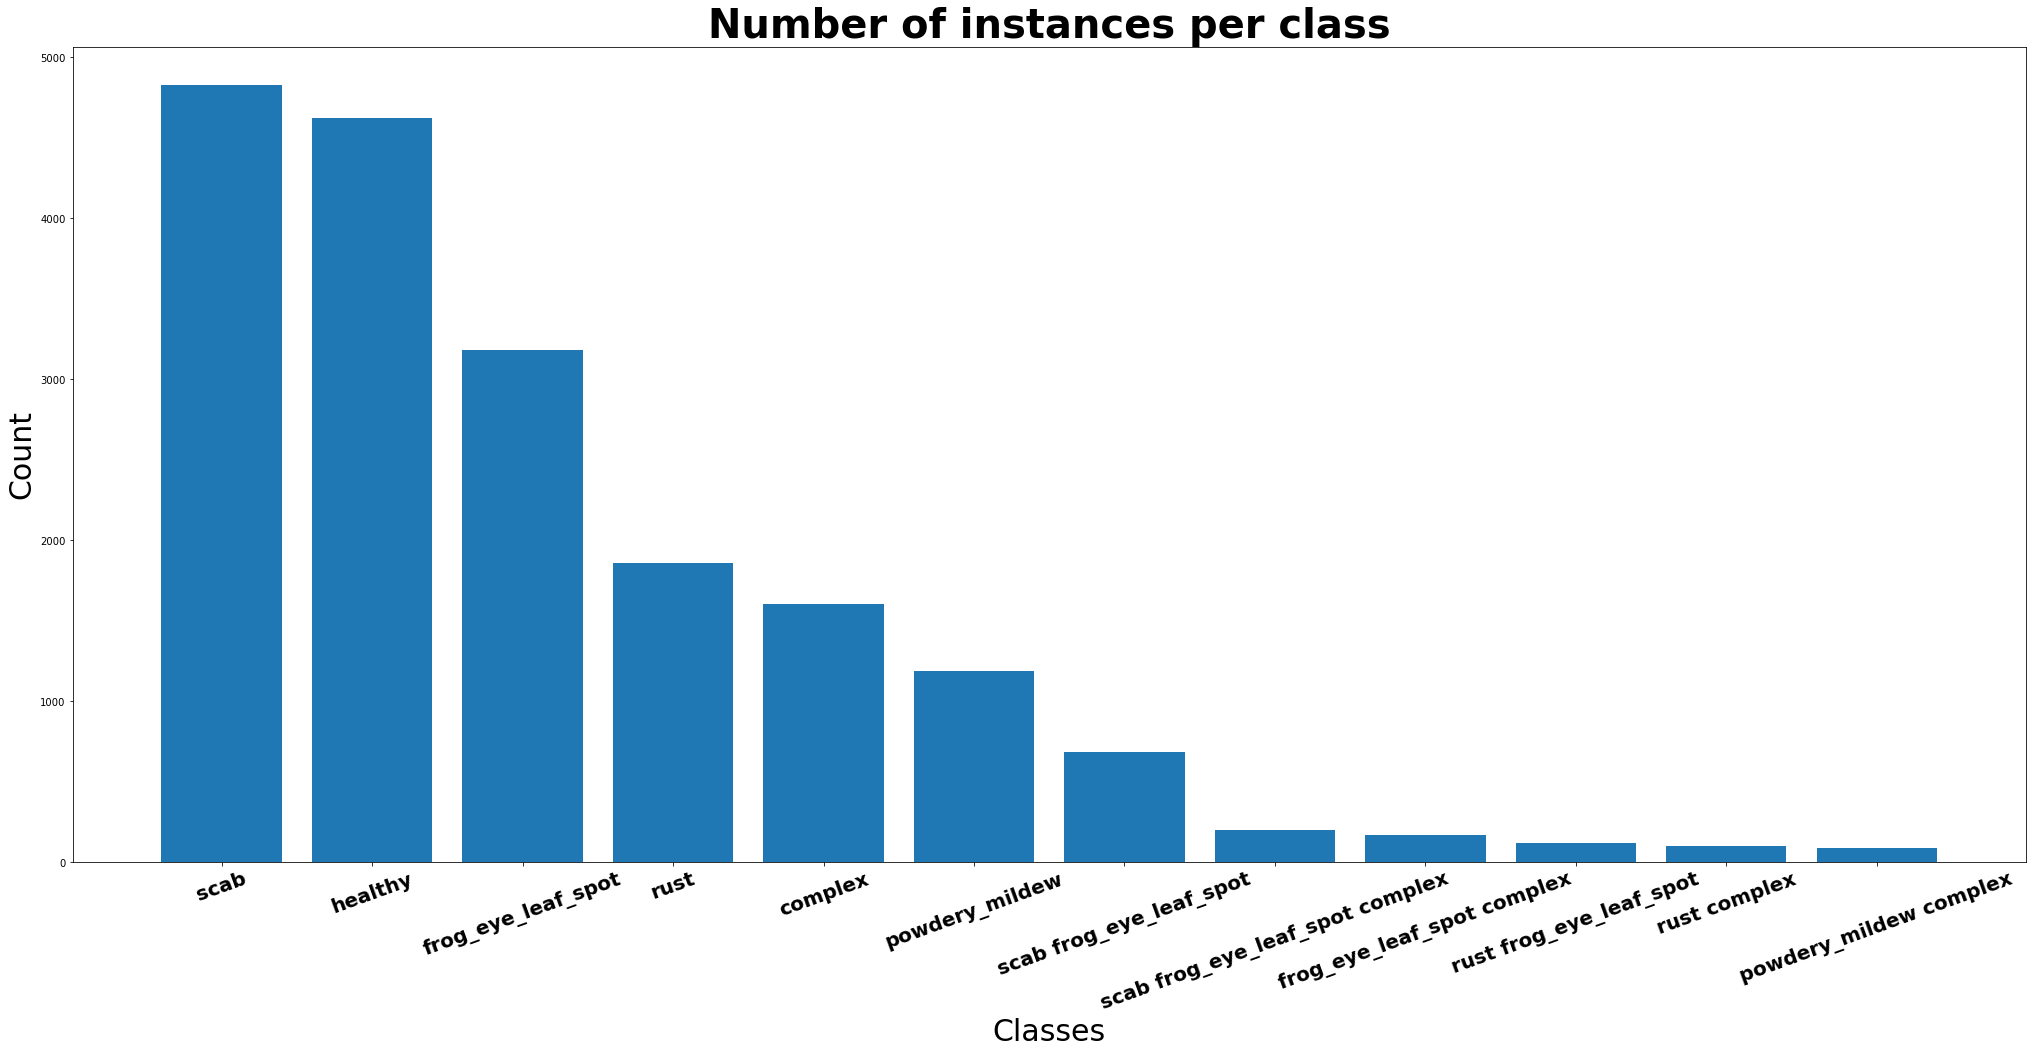

In [4]:
plt.figure(figsize=(35,15))
plt.bar(classes,classes_count)
plt.title("Number of instances per class",fontweight="bold",fontsize=40)
plt.xlabel("Classes",fontsize = 30)
plt.xticks(rotation=20,fontsize = 20,fontweight = "bold")
plt.xticks(fontsize = 20,fontweight = "bold")
plt.ylabel("Count",fontsize=30)
plt.show()

### It's a biased data

Also the image size are varying as follows:
## height = [1728,4032], width = [2592,5184]  

### I don't have enough GPU time, so I am using Image size as = [128,128]

In [5]:
'''h_ls,w_ls = [],[]
for img in os.listdir(TRAIN_PATH):
    im = PIL.Image.open(os.path.join(TRAIN_PATH,img))
    h_ls.append(im.height)
    w_ls.append(im.width)


plt.plot(h_ls,w_ls)
plt.xlabel("Height of Image")
plt.ylabel("Width of Image")
plt.title("Distribution of Image size of training data",fontweight = "bold")'''
print("Time Taking")

Time Taking


# Data Pipeline

### As the labels are given in csv file, data pipeline can be prepared by `tf.keras.preprocessing.image.ImageDataGenerator` and there by adding `.flow_from_dataframe` as attribute

In [6]:
'''NUM_CLASSES =  len(classes)
HEIGHT,WIDTH = 64,64
CHANNELS = 3
BATCH_SIZE = 32
SEED = 143
SPLIT = int(0.8*len(train_df))
AUTO = tf.data.experimental.AUTOTUNE


def process_img(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image

def process_label(filepath):
    parts = tf.strings.split(filepath, '/')
    filename = parts[-1]
    label = train_df[train_df["image"] == filename]["labels"][0]
    label = tf.one_hot(label,depth = NUM_CLASSES,dtype = tf.int32)
    return label

def get_image_label(filepath : tf.Tensor):
    image = tf.io.read_file(filepath)
    image = process_img(image)
    label = process_label(filepath)
    return image,label


def get_dataset(files_ds):
    dataset = files_ds.map(lambda x: tf.py_function(func=get_image_label,
                    inp=[x], Tout=(tf.float32,tf.int32)),
                    num_parallel_calls=tf.data.AUTOTUNE,
                    deterministic=False)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache().prefetch(AUTO)
    return dataset



files_ls = tf.io.gfile.glob(TRAIN_PATH + '*.jpg')
files_ds = tf.data.Dataset.list_files(files_ls)

train_ds = files_ds.take(SPLIT)
val_ds = files_ds.skip(SPLIT)

train_ds =get_dataset(train_ds)
val_ds =  get_dataset(val_ds)'''
print("Different Data Pipeline")

Different Data Pipeline


In [7]:
NUM_CLASSES =  len(classes)
HEIGHT,WIDTH = 128,128
BATCH_SIZE = 32
SEED = 143
SPLIT = 0.2

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = SPLIT,
    zoom_range = 0.2,
    shear_range = 0.2,
    vertical_flip = False
)

train_ds = datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "training",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

val_ds = datagen.flow_from_dataframe(
    train_df,
    directory = TRAIN_PATH,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "validation",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

Found 14906 non-validated image filenames belonging to 12 classes.
Found 3726 non-validated image filenames belonging to 12 classes.


# Model

In [8]:
def create_model():
    
    pretrained = efn.EfficientNetB0(include_top=False, weights='noisy-student',input_shape=[HEIGHT,WIDTH, 3])
            
    x = pretrained.output
    x = tf.keras.layers.GlobalAveragePooling2D() (x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES,activation="softmax", dtype='float32')(x)
        
    model = tf.keras.Model(pretrained.input, outputs)
    return model

model = create_model()
#model.summary()

16703488/16696600 [==============================] - 0s 0us/step


# Compiling the Model

In [9]:
import tensorflow_addons as tfa

def compile_model(model, lr=0.0001):
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    #tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
    metrics = [
    tfa.metrics.F1Score(num_classes = NUM_CLASSES,average = "macro",name = "f1_score")
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

# Callbacks Function

In [10]:
METRIC = "val_f1_score"

def create_callbacks(metric = METRIC):
    
    cpk_path = './best_model.h5'
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor= metric,
        mode='max',
        save_best_only=True,
        verbose=1,
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='max',
        factor=0.1,
        patience=3,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint, reducelr, earlystop]         
    
    return callbacks

# Training

In [11]:
EPOCHS= 3
VERBOSE =1

tf.keras.backend.clear_session()

with tf.device('/device:GPU:0'):
    
    model = create_model()
    model = compile_model(model, lr=0.0001)
   
    callbacks = create_callbacks()
    
    history = model.fit(
                        train_ds,
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=VERBOSE
                       )

Epoch 1/3
466/466 [==============================] - 3338s 7s/step - loss: 1.7135 - f1_score: 0.1966 - val_loss: 1.0207 - val_f1_score: 0.3347

Epoch 00001: val_f1_score improved from -inf to 0.33473, saving model to ./best_model.h5
Epoch 2/3
466/466 [==============================] - 3148s 7s/step - loss: 0.7599 - f1_score: 0.3903 - val_loss: 0.5862 - val_f1_score: 0.4190

Epoch 00002: val_f1_score improved from 0.33473 to 0.41896, saving model to ./best_model.h5
Epoch 3/3
466/466 [==============================] - 3176s 7s/step - loss: 0.6331 - f1_score: 0.4298 - val_loss: 0.5213 - val_f1_score: 0.4407

Epoch 00003: val_f1_score improved from 0.41896 to 0.44073, saving model to ./best_model.h5


# History plotting

In [12]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Categorical Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

KeyError: 'categorical_accuracy'

### If you have any doubts or suggestions feel free to contact me.
## Happy coding❤ 